# Salary Prediction Demo 01

In this demo, we go through the process of data ingestion and preparation; often the longest and most attritional stage of a machine learning project. 

The aim is **transform** raw data into a format that is suitable for machine learning model training.

Techniques

- ...

Challenges


- Retaining a dataset which is representative of the population

In [2]:
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

def describe_feature(x): 
    v = df_meta[df_meta['Var'] == x]['Description'].values
    if len(v) == 0:
        return ''
    else:
        return v[0]

# Stage 1 : Data Ingestion & Initial Measures

- Identify raw data
- Load it into an appropriate format for EDA

### 1.1 Download Raw Data

Our data ingestion is simple because we are use open source data; we can just grab it from the web!

In [ ]:
# here is our raw data, ingestion will simply download from a hosted location
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990raw.data.txt
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990raw.attributes.txt

### 1.2 Load Raw Data

We often have to write custom code to read the exact data format for each dataset... this code is stored elsewhere to avoid cluttering the notebook.

Data often has **metadata**; in this case the metadata is absolutely essential for understanding the data and we make use of it throughout.

In big data applications; loading the data this was is not feasible and we have to make use of other infrastructure like spark/aws.

In [7]:
from helper import load_data
import time

ROOT = r"/Users/tom.jubb/Documents/data/us_census/"

In [4]:
df_meta, all_codes = load_data(ROOT, verbose=False)

In [9]:
t0 = time.time()
df = pd.read_csv(os.path.join(ROOT,'USCensus1990raw.data.txt'), 
                 delimiter="\t", 
                 header=0, 
                 dtype=str)
df.columns = list(df_meta['Var'].values)
t1 = time.time()

print(fr"Loading complete... Took {t1-t0:.2f} seconds")

Loading complete... Took 23.31 seconds


### 1.3 Explore the basic data properties

To orient ourselves, we look at the basic properties of the data

- 2.5 M records
- Large feature set

The most basic thing we need to know is the data **Volume** (both the number of rows and columns)

In [10]:
print(f"Records:  {df.shape[0]}")
print(f"Features: {df.shape[1]}")

Records:  2458284
Features: 125


Now we look a little deeper into the **Features** (columns of data)... luckily we have enough metadata to provide some basic descriptions

In [11]:
for x in list(df.columns):
    print(f"{x:<20} - {describe_feature(x)}")

AAGE                 - Age Allocation Flag
AANCSTR1             - First Ancestry Allocation Flag
AANCSTR2             - Second Ancestry Allocation Flag
AAUGMENT             - Augmented Pers. See Text Pp. C 5
ABIRTHPL             - Place of Birth
ACITIZEN             - Citizenship Allocation Flag
ACLASS               - Class of Worker Allocation Flag
ADEPART              - Time of Departure to Work Allocation Fla
ADISABL1             - Work Limitation Stat. Allocation Flag
ADISABL2             - Work Prevention Stat. Allocation Flag
AENGLISH             - Ability to Speak English Allocation Flag
AFERTIL              - Chld. Ever Born Allocation Flag
AGE                  - Age
AHISPAN              - Detailed Hispanic Origin Allocation Flag
AHOUR89              - Usual Hrs. Worked Per Week in 1989 Alloc
AHOURS               - Hrs. Worked Last Week Allocation Flag
AIMMIGR              - Yr. of Entry Allocation Flag
AINCOME1             - Wages and Salary Inc. Allocation Flag
AINCOME2      

# Stage 2 :  Data Quality and Data Preparation

In this stage, the aim is to assure good data quality, and prepare the data for ML. This can entail a variety of things as we will see

### 2.1 Data Cleaning Example

We notice that a lot of these fields have the same names... it appears that many features are simply booleans indictaing that another field is populated or not....

We would do this in a much simpler way today

In [12]:
all_vars = list(df_meta['Var'])

vars_with_flag = []
for var in df_meta['Var']:
    if 'A'+var in all_vars:
        vars_with_flag += [var]

# convert to integer
for v in vars_with_flag:
    df['A'+v] = df['A'+v].astype('int')
    
df['AGE'] = df['AGE'].astype('int')

In [13]:
# how many of these fields are populated?
# df[['A'+ v for v in vars_with_flag]].sum(axis=0)

In [14]:
all_vars = list(df_meta['Var'])

vars_with_flag = []
for var in df_meta['Var']:
    if 'A'+var in all_vars:
        vars_with_flag += [var]

df = df.drop(['A' + v for v in vars_with_flag], axis=1)

In [15]:
alloc_flags = [
          'AANCSTR1',
          'AANCSTR2',
          'AAUGMENT',
          'ABIRTHPL',
          'ALABOR',
          'AHISPAN',
          'AINDUSTR',
          'ALSTWRK',
          'AMIGSTAT',
          'AMOBLLIM',
          'AMOBLTY',
          'APERCARE',
          'APOWST',
          'ATRAVTME',
          'AWKS89',
          'ASERVPER',
          'AVETS1']

for x in alloc_flags:
    print(f"{x:<20} - {describe_feature(x)}")
    print(df[x].unique())
    
# binary cols
df = df.drop(alloc_flags, axis=1)

AANCSTR1             - First Ancestry Allocation Flag
['0' '1']
AANCSTR2             - Second Ancestry Allocation Flag
['0' '1']
AAUGMENT             - Augmented Pers. See Text Pp. C 5
['0' '1']
ABIRTHPL             - Place of Birth
['0' '1']
ALABOR               - Employment Stat. Recode Allocation Flag
['0' '1']
AHISPAN              - Detailed Hispanic Origin Allocation Flag
['0' '1']
AINDUSTR             - Ind. Allocation Flag
['0' '1']
ALSTWRK              - Yr. Last Worked Allocation Flag
['0' '1']
AMIGSTAT             - Migration State Allocation Flag
['0' '1']
AMOBLLIM             - Mobility Limitation Stat. Allocation Fla
['0' '1']
AMOBLTY              - Mobility Stat. Allocation Flag
['0' '1']
APERCARE             - Personal Care Limitation Stat. Allocatio
['0' '1']
APOWST               - Place of Work State Allocation Flag
['0' '1']
ATRAVTME             - Travel Time to Work Allocation Flag
['0' '1']
AWKS89               - Wks. Worked in 1989 Allocation Flag
['0' '1']
ASERVPE

### 2.2 Identify Interesting Features, Remove unwanted features

This is by-hand feature engineering (typically feature engineering is also done using algorithms as we will see later)

In [16]:
# from the description we only need REARNING
df = df.drop(['INCOME1',
              'INCOME2',
              'INCOME3',
              'INCOME4',
              'INCOME5',
              'INCOME6',
              'INCOME7',
              'INCOME8',
              'RPINCOME'], axis=1)

**Numerical** fields are of primary importance to ML applications since numerical data is the most natural for ML; numbers form an ordered scale and therefore possess the idea of "greater than" and "distance"

In [17]:
# we cast numerical features to numerical data types
df['AGE']      = df['AGE'].astype(int)
df['REARNING'] = df['REARNING'].astype(float)
df['SEX']      = df["SEX"].astype(int)
df['FERTIL']   = df["FERTIL"].astype(int)
df['PWGT1']    = df['PWGT1'].astype(float)

# military years served
df['YRSSERV']    = df['YRSSERV'].astype(int)

**Cardinality** is an important property of categorical fields, it determines how many difference classes exist for the feature.

Low cardinatlity example : "Martial Status", "Sex"

High cardinality example : "Place of Birth", "Occupation"

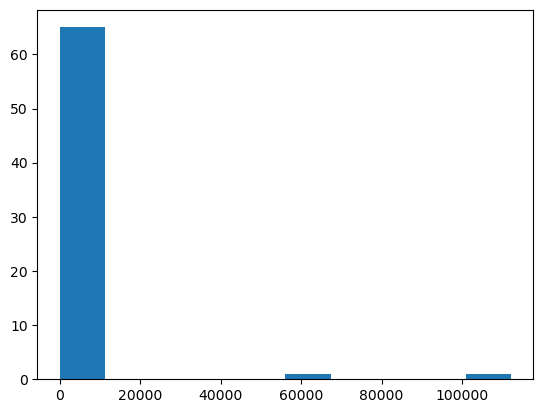

In [20]:
# cardinality
_ = plt.hist((df.nunique(axis=0).values))

In [27]:
df_unique = df.nunique(axis=0)
df_unique[df_unique > 600]


DEPART         757
REARNING     58310
SERIALNO    102640
dtype: int64

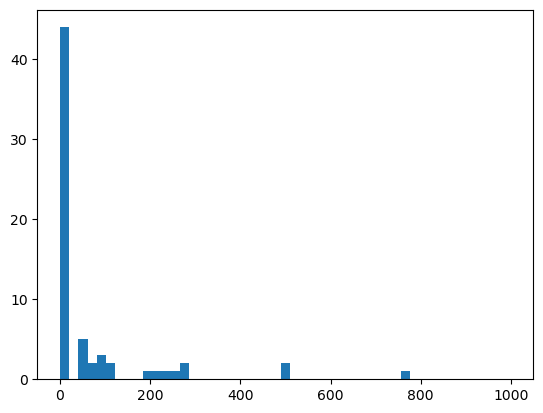

In [31]:
describe_feature('SERIALNO')
_ = plt.hist((df.nunique(axis=0).values), bins = np.linspace(0,1000,50))

In [32]:
# SERIALNO and POVERTY have very high cardinality but we don't know what they refer to, so drop.
df = df.drop('SERIALNO', axis=1)
df = df.drop('POVERTY', axis=1)

**Spoken Languages**

In [17]:
# remove <5 year olds, see all_codes['LANG1']
df = df[df['LANG1'] != '0']
df['multilingual'] = df['LANG1'].apply(lambda x: {'2':0, '1':1}[x])
df = df.drop('LANG1', axis=1)

# drop LANG2 since complex category
df = df.drop('LANG2', axis=1)

# ability to speak english
df = df[df['ENGLISH'] != '0']

**Family**

In [18]:
# "own child" means under 18, exclude these and drop column
df = df[df['ROWNCHLD'] == '0']
df = df.drop('ROWNCHLD', axis=1)

# drop RSPOUSE, since MARITAL provides duplicate information
df = df.drop('RSPOUSE', axis=1)

**Jobs**

In [21]:
df = df[df['CLASS'] != '0'] # child
df = df[df['CLASS'] != '9'] # unemployed

df['TRAVTIME'] = df['TRAVTIME'].astype('float') # travel time in minutes
df['HOURS']    = df['HOURS'].astype('float')    # hours worked last week
df['HOUR89']   = df['HOUR89'].astype('float')   # usual hours previous year

df['RLABOR'] = df['RLABOR'].apply(lambda x: x in ['1','2','4','5'])

df['DEPART'] = df['DEPART'].apply(lambda x: int(x[:2]) * 60 + int(x[2:])) # departure for work convert to minutes since midnight

df = df[df['POWSTATE'] != '00'] # doesn't work
df = df[df['POWSTATE'] != '99'] # remove works abroad

# turn to boolean did/did not work last week
df['WORKLWK'] = df['WORKLWK'].apply(lambda x: {'0':False,'1':True,'2':False}[x])

# exploring this feature it isn't doing a lot
df = df.drop('LOOKING', axis=1)

In [28]:
# TODO
# df['OCCUP'].apply(lambda x: all_codes['OCCUP'][x])
# df['INDUSTRY'].apply(lambda x: all_codes['INDUSTRY'][x])

**Encoding** : Un-encode some fields so the data is easier to view, we can re-encode later

In [33]:
# convert to text for easier reading
df['RACE']         = df['RACE'].apply(lambda x: all_codes['RACE'][x])
df['SEX']          = df['SEX'].apply(lambda x:  all_codes['SEX'][str(x)])
df['MARITAL']      = df['MARITAL'].apply(lambda x: all_codes['MARITAL'][x])
df['CLASS']        = df['CLASS'].apply(lambda x: all_codes['CLASS'][x])
df['YEARSCH_CAT']  = df['YEARSCH'].apply(lambda x: all_codes['YEARSCH'][x])
df['MEANS']        = df['MEANS'].apply(lambda x: all_codes['MEANS'][x])

# Location
df['MIGSTATE']     = df['POWSTATE'].apply(lambda x: all_codes['POWSTATE'][str(x).zfill(2)])
df['POWSTATE']     = df['POWSTATE'].apply(lambda x: all_codes['POWSTATE'][str(x).zfill(2)])
df['POB']          = df['POB'].apply(lambda x: all_codes['POB'][str(x).zfill(3)])
df['RPOB']         = df['RPOB'].apply(lambda x: all_codes['RPOB'][str(x)])

df['RSPOUSE']      = df['RSPOUSE'].apply(lambda x: all_codes['RSPOUSE'][str(x)])
df['RAGECHLD']     = df['RAGECHLD'].apply(lambda x: all_codes['RAGECHLD'][str(x)])

**Summary** : What features do we have left... This looks a lot better with far more recognizable features that we would expect to have an influence on results

In [34]:
for x in list(df.columns):
    try:
        print(f"{x:<20} - {describe_feature(x)}")
    except:
        print(x)

AGE                  - Age
ANCSTRY1             - Ancestry First Entry See Appendix I Ance
ANCSTRY2             - Ancestry Second Entry See Appendix I Anc
AVAIL                - Available for Work
CITIZEN              - Citizenship
CLASS                - Class of Worker
DEPART               - Time of Departure for Work Hour and Minu
DISABL1              - Work Limitation Stat.
DISABL2              - Work Prevented Stat.
ENGLISH              - Ability to Speak English
FEB55                - Served February 1955 July 1964
FERTIL               - No. of Chld. Ever Born
HISPANIC             - Detailed Hispanic Origin Code See Append
HOUR89               - Usual Hrs. Worked Per Week Last Yr. 1989
HOURS                - Hrs. Worked Last Week
IMMIGR               - Yr. of Entry
INDUSTRY             - Ind. See Appendix I Ind..lst
KOREAN               - Served Korean Conflict June 1950 January
LANG1                - Language Other Than English At Home
LANG2                - Language Spoken At Ho

### 2.3 An example of adjusting feature to reduce imbalance

Let's look at the "CITIZEN" feature

In [37]:
describe_feature('CITIZEN')

'Citizenship'

In [39]:
# the available values of CITIZEN
all_codes['CITIZEN']

{'0': 'Born in the U.S.',
 '1': 'Born in Puerto Rico, Guam, and Outlying',
 '2': 'Born Abroad of American Parents',
 '3': 'U.S. Citizen by Naturalization',
 '4': 'Not a Citizen of the U.s'}

In [41]:
# check class counts -> highly imbalanced
df.groupby('CITIZEN').count()['PWGT1']

CITIZEN
0    1009356
1       5023
2       7602
3      40668
4      55808
Name: PWGT1, dtype: int64

We fix this imbalance by mapping some values into others; for example do we really expect the different types of USA citizenship to make a difference? We have to consider the greater potential for imbalance to distort or bias results... We can still retain the feature but we should simplify the classes to IS/ISN'T a US citizen

In [42]:
citizen_map = {
    '0':True,
    '1':True,
    '2':True,
    '3':True,
    '4':False
}
df['CITIZEN'] = df['CITIZEN'].apply(lambda x: citizen_map[x])

In [43]:
# this class is now much more balanced
df.groupby('CITIZEN').count()['AGE']

CITIZEN
False      55808
True     1062649
Name: AGE, dtype: int64

We can apply this also to military service

In [50]:
df.groupby('MILITARY').count()['AGE']

MILITARY
1     14831
2    168855
3     25473
4    909298
Name: AGE, dtype: int64

In [51]:
print(describe_feature('MILITARY'))
all_codes['MILITARY']

military_map = {
    '0':False,
    '1':True,
    '2':True,
    '3':True,
    '4':False
}
print(all_codes['MILITARY'])
df['MILITARY'] = df['MILITARY'].apply(lambda x: military_map[x])

Military Srvc.
{'0': 'N/a Less Than 16 Yrs. Old', '1': 'Yes, Now on Active Duty', '2': 'Yes, on Active Duty in Past, But Not Now', '3': 'Yes, Srvc. in Reserves or Nat. Guard Onl', '4': 'No Srvc.'}


In [52]:
df.groupby('MILITARY').count()['AGE']

MILITARY
False    909298
True     209159
Name: AGE, dtype: int64

### 2.4. Assessing Data Quality

- Focus on features we care about.
- Basic checks for anomalous values.
- Use domain knolwedge to assist in providing quality checks
- Look at consistency with other features -> e.g. no 5 year olds served in WWII

In [53]:
describe_feature('AGE')

'Age'

In [54]:
# all the ages present
x = df['AGE'].unique()
x.sort()

# that's a bit fishy... there are definitely people aged over 90 
print(f"Min age {x.min()}, Max age {x.max()}")

# assertions are how we capture quality checks
assert np.unique(np.diff(x)) == 1

print(x)

Min age 16, Max age 90
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90]


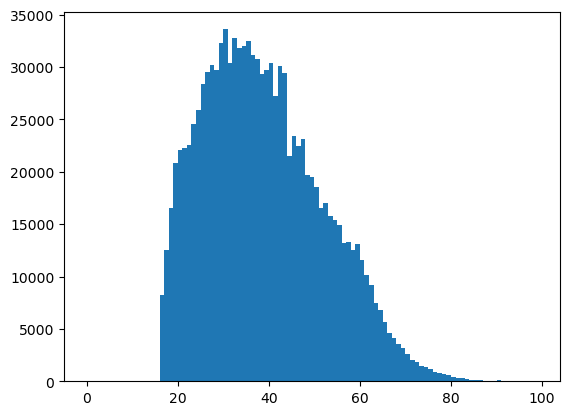

In [56]:
# ah... a deeper look at the data reveals an anomalously high point at 90... 
# it is likley that everyone aged over 90 was counted as being 90
_ = plt.hist(df['AGE'], bins=np.arange(0,100,1))

In [35]:
# How many served in WWII? 4%
df[['AGE', 'WWII']].astype(int).groupby('WWII').count()

,AGE
WWII,
0,136408
1,1562


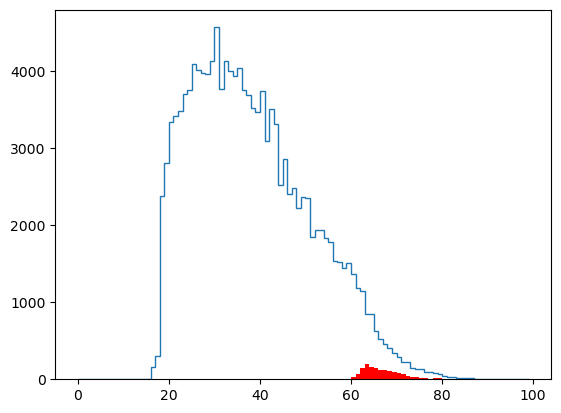

In [36]:
df_ww2 = df[['AGE', 'WWII']].astype(int)

_ = plt.hist(df['AGE'], bins=np.arange(0,100,1), histtype='step')
_ = plt.hist(df_ww2[df_ww2['WWII'] == 1]['AGE'], bins=np.arange(0,100,1), color='r')

In [37]:
# can we find other wars represented?
df_meta[df_meta['Description'].apply(lambda x: "served" in x.lower())]

,Var,Type,Des,Len,Description
59,FEB55,C,X,1,Served February 1955 July 1964
74,KOREAN,C,X,1,Served Korean Conflict June 1950 January
79,MAY75880,C,X,1,Served May 1975 to August 1980
87,OTHRSERV,C,X,1,Served Any Other Time
110,SEPT80,C,X,1,Served September 1980 or Later
117,VIETNAM,C,X,1,Served Vietnam Era August 1964 April 197
121,WWII,C,X,1,Served World War II September 1940 July


In [38]:
service_cols = ['WWII', 'VIETNAM', 'KOREAN']
colors = ['r', 'g', 'b']

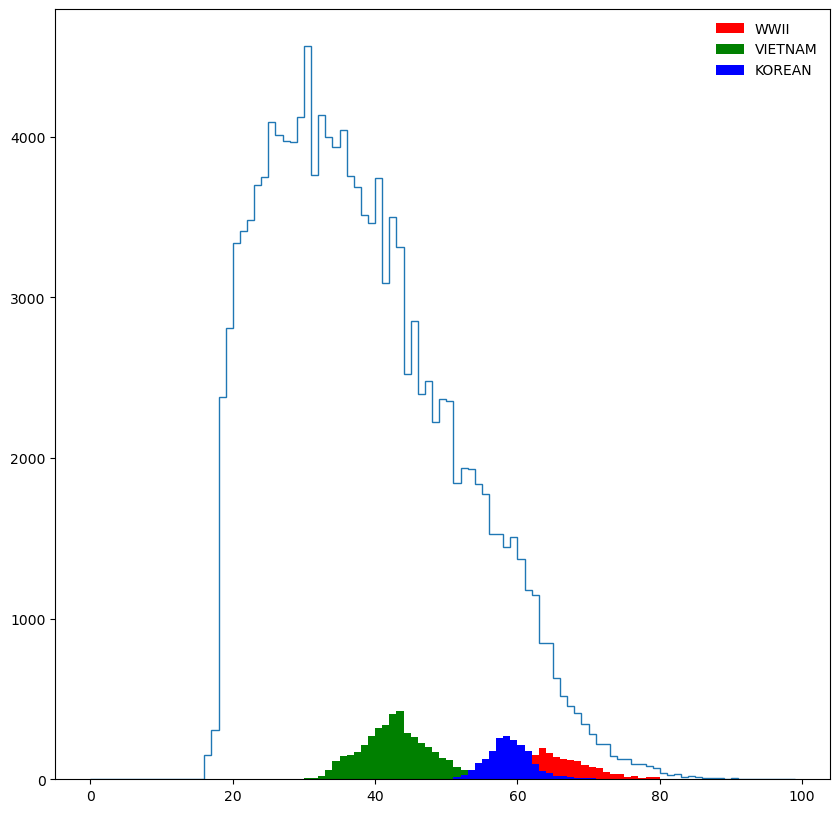

In [39]:

fig, ax = plt.subplots(1,1,figsize=(10,10))

for i, w in enumerate(service_cols):
    df_war = df[['AGE', w]].astype(int)
    _ = ax.hist(df_war[df_war[w] == 1]['AGE'], bins=np.arange(0,100,1), 
                 color=colors[i], label=w)
    

_ = ax.hist(df['AGE'], bins=np.arange(0,100,1), histtype='step')

ax.legend(frameon=False)


### 2.4 By-Hand Feature Engineering : Occupations

There are some very high caridnality features like Occupation that we need to spend quite a bit of time on to.

In [76]:
from bs4 import BeautifulSoup
import re

In [77]:
describe_feature('OCCUPATION')

''

In [58]:
with open(ROOT + '/USCensus1990raw.coding.htm', 'r') as f:
    html_text=f.read()
soup = BeautifulSoup(html_text, 'html.parser')

In [59]:
lines = soup.body.pre.text.split('\n')
i_start = [i for i,l in enumerate(lines) if 'OCCUPATION' in l][0]
i_stop = [i for i,l in enumerate(lines) if 'PLACE OF BIRTH' in l][0]

occups = lines[i_start:i_stop-1]
occups = [line for line in occups if len(line)>1]

# remove wrapped lines
occups_2 = []
for o in occups:
    if o.startswith('   '):
        occups_2[-1] += o.strip()
    else:
        occups_2 += [o]
occups = occups_2
del occups_2

In [60]:
# split the individual jobs from their groupings (it's all in the same list)

pattern = re.compile('[0-9][0-9][0-9]-[0-9][0-9][0-9] *')
occups_single = [o for o in occups if pattern.match(o) is None]
occups_group  = [o for o in occups if pattern.match(o) is not None]

df_jobs   = pd.DataFrame([[o[:4].strip(), o[4:].strip()] 
                          for o in occups_single[8:]], columns=['Code', 'Job']) 
df_groups = pd.DataFrame([[o[:3], o[4:7], o[7:].strip()] 
                          for o in occups_group], columns=['Code min', 'Code max', 'Job']) 
df_groups['range'] = df_groups['Code max'].astype(int) - df_groups['Code min'].astype(int)

In [61]:
# how many codes are not present in the single job rows?

jobs = list(df_jobs['Code'].values)

jobs_not_in_list = []
for i in df['OCCUP'].unique():
    if str(i).zfill(3) not in jobs:
        jobs_not_in_list += [i]
        
print(f"{len(jobs_not_in_list)} out of {len(df['OCCUP'].unique())}")

129 out of 504


In [62]:
# identify summary groups by large ranges and capitalization

summary_group_list = [
 'MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS',        # 0-202
 'TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT OCCUPATIONS', # 203-402
 'SERVICE OCCUPATIONS',                                      # 403-472
 'PRECISION PRODUCTION, CRAFT, AND REPAIR OCCUPATIONS',      # 503-702
 'OPERATORS, FABRICATORS, AND LABORERS',                     # 703-902
 'MILITARY OCCUPATIONS (Includes only uniquely military    occupations.Other Armed Forces members are coded to civilian occupations.)', 
                                                             # 903-908
 'EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY OCCUPATION'       # 909-999
]

df_groups.sort_values('range', ascending=False).head(50)

df_summary_groups = df_groups[df_groups['Job'].apply(lambda x: x in summary_group_list)]
df_summary_groups


,Code min,Code max,Job,range
0,000,202,MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS,202
40,203,402,"TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT O...",199
86,403,472,SERVICE OCCUPATIONS,69
116,503,702,"PRECISION PRODUCTION, CRAFT, AND REPAIR OCCUPA...",199
172,703,902,"OPERATORS, FABRICATORS, AND LABORERS",199
227,903,908,MILITARY OCCUPATIONS (Includes only uniquely m...,5
229,909,999,EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY OCCUP...,90


In [63]:
df_groups.sort_values('range', ascending=False).head(10)['Job'].values

array(['MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS',
       'OPERATORS, FABRICATORS, AND LABORERS',
       'PRECISION PRODUCTION, CRAFT, AND REPAIR OCCUPATIONS',
       'TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT OCCUPATIONS',
       'Professional Specialty Occupations',
       'Machine Operators, Assemblers, and Inspectors',
       'Administrative Support Occupations, Including Clerical',
       'EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY OCCUPATION',
       'Unemployed, last worked 1984 or earlier',
       'Machine Operators and Tenders, Except Precision'], dtype=object)

In [64]:
# add in the missing job codes using the lowest cardinality grouping
for i in range(1000):
    code = str(i).zfill(3)
    if df_jobs[df_jobs['Code'] == code].shape[0] ==0:
        # add code to frame with job cat..
        matches = df_groups[(df_groups['Code min'] <= code) & (df_groups['Code max'] >= code)]
        the_job = matches.sort_values('range').iloc[0]['Job']
        df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
df_jobs = df_jobs.sort_values('Code').reset_index().drop('index',axis=1)

/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is dep

/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is dep

In [65]:
df_jobs.head(5)

,Code,Job
0,000,Legislators (111)
1,001,Legislators (111)
2,002,Legislators (111)
3,003,Legislators (111)
4,004,"Chief executives and general administrators, p..."


In [66]:
# remove the summary groups from the group frame
df_groups = df_groups[df_groups['Job'].apply(lambda x: x not in summary_group_list)]
df_groups

,Code min,Code max,Job,range
1,000,042,"Executive, Administrative, and Managerial Occu...",42
2,000,003,Legislators (111),3
3,009,012,Purchasing managers (124),3
4,019,020,Funeral directors (part 1359),1
5,023,042,Management Related Occupations,19
...,...,...,...,...
224,883,884,"Freight, stock, and material handlers, n.e.c. ...",1
225,885,886,Garage and service station related occupations...,1
226,889,902,"Laborers, except construction (8769)",13
228,905,908,"Military occupation, rank not specified",3


In [67]:
# determine how many other groups each group contains
conts = {}
for i, row in df_groups.iterrows():
    r1 = int(row['Code min'])
    r2 = int(row['Code max'])
    conts[row['Job']] = []
    for j, rowj in df_groups.iterrows():
        if int(rowj['Code min']) >= r1 and int(rowj['Code max']) <= r2:
            conts[row['Job']] += [rowj['Job']]
major_group_list = [k for k,v in conts.items() if len(v)>5]

In [68]:
for k,v in conts.items():
    print(k, len(v))

Executive, Administrative, and Managerial Occupations 7
Legislators (111) 1
Purchasing managers (124) 1
Funeral directors (part 1359) 1
Management Related Occupations 3
Buyers, wholesale and retail trade except farm products (1442) 1
Management related occupations, n.e.c. (149) 1
Professional Specialty Occupations 32
Engineers, Architects, and Surveyors 4
Engineers 3
Nuclear (1627) 1
Engineers, n.e.c. (1639) 1
Mathematical and Computer Scientists 1
Natural Scientists 3
Physicists and astronomers (1842, 1843) 1
Forestry and conservation scientists (1852) 1
Health Diagnosing Occupations 2
Health diagnosing practitioners, n.e.c. (289) 1
Health Assessment and Treating Occupations 4
Therapists 2
Occupational therapists (3032) 1
Physicians' assistants (304) 1
Teachers, Postsecondary 5
Economics teachers (2218) 1
Computer science teachers (2228) 1
Education teachers (2237) 1
Home economics teachers (2247) 1
Teachers, Except Postsecondary 2
Teachers, n.e.c. (236, 239) 1
Librarians, Archivists,

In [69]:
major_group_list = [
    'Executive, Administrative, and Managerial Occupations',   # 0-42
    'Professional Specialty Occupations',                      # 43-202
    'Technicians and Related Support Occupations',             # 203-242
     'Sales Occupations',                                      # 243-302
    'Administrative Support Occupations, Including Clerical',  # 303-402
    
    'Protective Service Occupations',                          # 413-432
    'Service Occupations, Except Protective and Household',    # 433-472
    
     'Mechanics and Repairers',                                # 503-552
#      'Mechanics and Repairers, Except Supervisors'
     'Construction Trades',                                    # 553-612
#      'Construction Trades, Except Supervisors',
    
     'Precision Production Occupations',                       # 628-702
     'Machine Operators, Assemblers, and Inspectors',          # 703-802
#      'Machine Operators and Tenders, Except Precision',
     'Transportation and Material Moving Occupations',         # 803-863
     'Handlers, Equipment Cleaners, Helpers, and Laborers',    # 864-902
     'MILITARY OCCUPATIONS (Includes only uniquely military    occupations.Other Armed Forces members are coded to civilian occupations.)', 
                                                               # 903-908
     'EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY OCCUPATION'     # 909-999
]

df_major_groups = df_groups[df_groups['Job'].apply(lambda x: x in major_group_list)]
df_major_groups

,Code min,Code max,Job,range
1,000,042,"Executive, Administrative, and Managerial Occu...",42
8,043,202,Professional Specialty Occupations,159
41,203,242,Technicians and Related Support Occupations,39
51,243,302,Sales Occupations,59
61,303,402,"Administrative Support Occupations, Including ...",99
89,413,432,Protective Service Occupations,19
96,433,472,"Service Occupations, Except Protective and Hou...",39
117,503,552,Mechanics and Repairers,49
134,553,612,Construction Trades,59
150,628,702,Precision Production Occupations,74


In [70]:
df_groups[df_groups['Job'].apply(lambda x: x in major_group_list)]

,Code min,Code max,Job,range
1,000,042,"Executive, Administrative, and Managerial Occu...",42
8,043,202,Professional Specialty Occupations,159
41,203,242,Technicians and Related Support Occupations,39
51,243,302,Sales Occupations,59
61,303,402,"Administrative Support Occupations, Including ...",99
89,413,432,Protective Service Occupations,19
96,433,472,"Service Occupations, Except Protective and Hou...",39
117,503,552,Mechanics and Repairers,49
134,553,612,Construction Trades,59
150,628,702,Precision Production Occupations,74


In [71]:
list(df_groups[df_groups['Job'].apply(lambda x: x in major_group_list)]['Job'])

['Executive, Administrative, and Managerial Occupations',
 'Professional Specialty Occupations',
 'Technicians and Related Support Occupations',
 'Sales Occupations',
 'Administrative Support Occupations, Including Clerical',
 'Protective Service Occupations',
 'Service Occupations, Except Protective and Household',
 'Mechanics and Repairers',
 'Construction Trades',
 'Precision Production Occupations',
 'Machine Operators, Assemblers, and Inspectors',
 'Transportation and Material Moving Occupations',
 'Handlers, Equipment Cleaners, Helpers, and Laborers']

In [72]:
# define the mappings of code -> Group

# ======= JOBS   ======================
jobs_map = {row['Code']:row['Job'] for i,row in df_jobs.iterrows()}

# ======= SUMMARY GROUPS ==============
summary_group_map = {}
for i in range(1000):
    code = str(i).zfill(3)

    # add code to frame with job cat..
    matches = df_summary_groups[  (df_summary_groups['Code min'] <= code) 
                                & (df_summary_groups['Code max'] >= code)]
    assert matches.shape[0] <= 1
    
    if matches.shape[0] == 0:
        summary_group_map[code] = 'UNKNOWN'
    else:
        summary_group_map[code] = matches['Job'].values[0]
        

# ======= MAJOR GROUPS =================
major_group_map = {}
for i in range(1000):
    code = str(i).zfill(3)

    # add code to frame with job cat..
    matches = df_major_groups[  (df_major_groups['Code min'] <= code) 
                                & (df_major_groups['Code max'] >= code)]
    assert matches.shape[0] <= 1
    
    if matches.shape[0] == 0:
        major_group_map[code] = 'UNKNOWN'
    else:
        major_group_map[code] = matches['Job'].values[0]

In [73]:
# apply the maps

df['OCCUP_JOB'] = df['OCCUP'].apply(lambda x: jobs_map[str(x).zfill(3)])
df['OCCUP_SUM'] = df['OCCUP'].apply(lambda x: summary_group_map[str(x).zfill(3)])
df['OCCUP_MAJ'] = df['OCCUP'].apply(lambda x: major_group_map[str(x).zfill(3)])

In [74]:
# quality checks

print(f"JOB Percentage unknown : {100*sum(df['OCCUP_JOB'] =='UNKNOWN') / df.shape[0]:.2f}%")
print(f"SUM Percentage unknown : {100*sum(df['OCCUP_SUM'] =='UNKNOWN') / df.shape[0]:.2f}%")
print(f"MAJ Percentage unknown : {100*sum(df['OCCUP_MAJ'] =='UNKNOWN') / df.shape[0]:.2f}%")

JOB Percentage unknown : 0.00%
SUM Percentage unknown : 2.92%
MAJ Percentage unknown : 3.89%


### 2.5 By-hand Feature Engineering Industry

In [78]:
describe_feature('INDUSTRY')

'Ind. See Appendix I Ind..lst'

In [79]:
lines = soup.body.pre.text.split('\n')
i_start = [i for i,l in enumerate(lines) if 'INDUSTRY' in l][0]
i_stop = [i for i,l in enumerate(lines) if 'LANGUAGE' in l][0]

industry = lines[i_start:i_stop-1]
industry = [line for line in industry if len(line)>1]

# remove wrapped lines
industry_2 = []
for o in industry:
    if o.startswith('   '):
        industry_2[-1] += o.strip()
    else:
        industry_2 += [o]
industry = industry_2
del industry_2

# cut away header
industry = industry[8:]

In [80]:
industry

['000-039       AGRICULTURE, FORESTRY, AND FISHERIES',
 '000-010       Agricultural production, crops  (01)',
 '011           Agricultural production, livestock  (02)',
 '012           Veterinary services  (074)',
 '013-020       Landscape and horticultural services  (078)',
 '021-030       Agricultural services, n.e.c.  (071, 072, 075, 076)',
 '031           Forestry (08)',
 '032-039       Fishing, hunting, and trapping  (09)',
 '040-059       MINING',
 '040           Metal mining  (10)',
 '041           Coal mining  (12)',
 '042           Oil and gas extraction  (13)',
 '043-059       Nonmetallic mining and quarrying, except fuel  (14)',
 '060-099       CONSTRUCTION (15, 16, 17)',
 '100-399       MANUFACTURING',
 '100-229       Nondurable Goods',
 '100-129       Food and kindred products',
 '100             Meat products  (201)',
 '101             Dairy products (202)',
 '102-109         Canned, frozen and preserved fruits and vegetables (203)',
 '110             Grain mill products 

In [81]:
# split the individual jobs from their groupings (it's all in the same list)

pattern = re.compile('[0-9][0-9][0-9]-[0-9][0-9][0-9] *')
occups_single = [o for o in industry  if pattern.match(o) is None]
occups_group  = [o for o in industry  if pattern.match(o) is not None]

df_jobs   = pd.DataFrame([[o[:4].strip(), o[4:].strip()] 
                          for o in occups_single[8:]], columns=['Code', 'Job']) 
df_groups = pd.DataFrame([[o[:3], o[4:7], o[7:].strip()] 
                          for o in occups_group], columns=['Code min', 'Code max', 'Job']) 
df_groups['range'] = df_groups['Code max'].astype(int) - df_groups['Code min'].astype(int)

In [82]:
df_groups

,Code min,Code max,Job,range
0,000,039,"AGRICULTURE, FORESTRY, AND FISHERIES",39
1,000,010,"Agricultural production, crops (01)",10
2,013,020,Landscape and horticultural services (078),7
3,021,030,"Agricultural services, n.e.c. (071, 072, 075,...",9
4,032,039,"Fishing, hunting, and trapping (09)",7
...,...,...,...,...
126,942,949,Navy,7
127,952,959,"Armed Forces, Branch not specified",7
128,960,991,Military Reserves or National Guard,31
129,992,999,EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY INDUSTRY,7


In [83]:
# how many codes are not present in the single job rows?

jobs = list(df_jobs['Code'].values)

jobs_not_in_list = []
for i in df['INDUSTRY'].unique():
    if str(i).zfill(3) not in jobs:
        jobs_not_in_list += [i]
        
print(f"{len(jobs_not_in_list)} out of {len(df['INDUSTRY'].unique())}")

100 out of 243


In [84]:
df_groups[df_groups['Code min'] == '040']

,Code min,Code max,Job,range
5,040,059,MINING,19


In [85]:
df_groups.sort_values('range', ascending=False).head(25)

,Code min,Code max,Job,range
8,100,399,MANUFACTURING,299
33,230,399,Durable Goods,169
9,100,229,Nondurable Goods,129
80,580,699,RETAIL TRADE,119
58,400,499,"TRANSPORTATION, COMMUNICATIONS, AND OTHER PUBL...",99
109,812,899,PROFESSIONAL AND RELATED SERVICES,87
69,500,579,WHOLESALE TRADE,79
124,940,991,ACTIVE DUTY MILITARY,51
66,450,499,Utilities and sanitary services,49
119,900,939,PUBLIC ADMINISTRATION,39


In [86]:
# identify summary groups by large ranges and capitalization

summary_group_list = [
 'AGRICULTURE, FORESTRY, AND FISHERIES' ,                      # 000-039
 'MINING',                                                     # 040-059
 'CONSTRUCTION (15, 16, 17)',                                  # 060-099
 'MANUFACTURING',                                              # 100-399
 'TRANSPORTATION, COMMUNICATIONS, AND OTHER PUBLIC UTILITIES', # 400-499
 'WHOLESALE TRADE',                                            # 500-579
 'RETAIL TRADE',                                               # 580-699
 'FINANCE, INSURANCE, AND REAL ESTATE',                        # 700-720
 'BUSINESS AND REPAIR SERVICES',                               # 721-760
 'PERSONAL SERVICES',                                          # 761-799
 'ENTERTAINMENT AND RECREATION SERVICES',                      # 800-811
 'PROFESSIONAL AND RELATED SERVICES',                          # 812-899
 'PUBLIC ADMINISTRATION',                                      # 900-939
 'ACTIVE DUTY MILITARY',                                       # 940-991
 'EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY INDUSTRY'           # 992-999
]

df_summary_groups = df_groups[df_groups['Job'].apply(lambda x: x in summary_group_list)]

# # remove the summary groups from the group frame
# df_groups = df_groups[df_groups['Job'].apply(lambda x: x not in summary_group_list)]
# df_groups

df_summary_groups

,Code min,Code max,Job,range
0,000,039,"AGRICULTURE, FORESTRY, AND FISHERIES",39
5,040,059,MINING,19
7,060,099,"CONSTRUCTION (15, 16, 17)",39
8,100,399,MANUFACTURING,299
58,400,499,"TRANSPORTATION, COMMUNICATIONS, AND OTHER PUBL...",99
69,500,579,WHOLESALE TRADE,79
80,580,699,RETAIL TRADE,119
93,700,720,"FINANCE, INSURANCE, AND REAL ESTATE",20
96,721,760,BUSINESS AND REPAIR SERVICES,39
101,761,799,PERSONAL SERVICES,38


In [87]:
df_groups.head(10)

,Code min,Code max,Job,range
0,000,039,"AGRICULTURE, FORESTRY, AND FISHERIES",39
1,000,010,"Agricultural production, crops (01)",10
2,013,020,Landscape and horticultural services (078),7
3,021,030,"Agricultural services, n.e.c. (071, 072, 075,...",9
4,032,039,"Fishing, hunting, and trapping (09)",7
5,040,059,MINING,19
6,043,059,"Nonmetallic mining and quarrying, except fuel ...",16
7,060,099,"CONSTRUCTION (15, 16, 17)",39
8,100,399,MANUFACTURING,299
9,100,229,Nondurable Goods,129


In [88]:
# add in the missing job codes using the lowest cardinality grouping
for i in range(1000):
    code = str(i).zfill(3)
    if df_jobs[df_jobs['Code'] == code].shape[0] ==0:
        # add code to frame with job cat..
        matches = df_groups[(df_groups['Code min'] <= code) & (df_groups['Code max'] >= code)]
        the_job = matches.sort_values('range').iloc[0]['Job']
        df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
df_jobs = df_jobs.sort_values('Code').reset_index().drop('index',axis=1)

/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is dep

/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is dep

/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is dep

/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is dep

/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_jobs = df_jobs.append({'Code':code, 'Job':the_job}, ignore_index=True)
/var/folders/5h/f90lxdwx30g73cny2g94t7h80000gp/T/ipykernel_28340/1414629348.py:8: FutureWarning: The frame.append method is dep

In [89]:
df_jobs.head(35)

,Code,Job
0,000,"Agricultural production, crops (01)"
1,001,"Agricultural production, crops (01)"
2,002,"Agricultural production, crops (01)"
3,003,"Agricultural production, crops (01)"
4,004,"Agricultural production, crops (01)"
5,005,"Agricultural production, crops (01)"
6,006,"Agricultural production, crops (01)"
7,007,"Agricultural production, crops (01)"
8,008,"Agricultural production, crops (01)"
9,009,"Agricultural production, crops (01)"


In [90]:
df_summary_groups

,Code min,Code max,Job,range
0,000,039,"AGRICULTURE, FORESTRY, AND FISHERIES",39
5,040,059,MINING,19
7,060,099,"CONSTRUCTION (15, 16, 17)",39
8,100,399,MANUFACTURING,299
58,400,499,"TRANSPORTATION, COMMUNICATIONS, AND OTHER PUBL...",99
69,500,579,WHOLESALE TRADE,79
80,580,699,RETAIL TRADE,119
93,700,720,"FINANCE, INSURANCE, AND REAL ESTATE",20
96,721,760,BUSINESS AND REPAIR SERVICES,39
101,761,799,PERSONAL SERVICES,38


In [91]:
df_jobs

,Code,Job
0,000,"Agricultural production, crops (01)"
1,001,"Agricultural production, crops (01)"
2,002,"Agricultural production, crops (01)"
3,003,"Agricultural production, crops (01)"
4,004,"Agricultural production, crops (01)"
...,...,...
995,995,EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY INDUSTRY
996,996,EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY INDUSTRY
997,997,EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY INDUSTRY
998,998,EXPERIENCED UNEMPLOYED NOT CLASSIFIED BY INDUSTRY


In [92]:
# define the mappings of code -> Group

# ======= JOBS   ======================
jobs_map = {row['Code']:row['Job'] for i,row in df_jobs.iterrows()}

# ======= SUMMARY GROUPS ==============
summary_group_map = {}
for i in range(1000):
    code = str(i).zfill(3)

    # add code to frame with job cat..
    matches = df_summary_groups[  (df_summary_groups['Code min'] <= code) 
                                & (df_summary_groups['Code max'] >= code)]
    assert matches.shape[0] <= 1
    
    if matches.shape[0] == 0:
        summary_group_map[code] = 'UNKNOWN'
    else:
        summary_group_map[code] = matches['Job'].values[0]

In [93]:
# apply the maps

df['INDUSTRY_CAT'] = df['INDUSTRY'].apply(lambda x: jobs_map[str(x).zfill(3)])
df['INDUSTRY_SUM'] = df['INDUSTRY'].apply(lambda x: summary_group_map[str(x).zfill(3)])

In [94]:
# quality checks

print(f"JOB Percentage unknown : {100*sum(df['INDUSTRY_CAT'] =='UNKNOWN') / df.shape[0]:.2f}%")
print(f"SUM Percentage unknown : {100*sum(df['INDUSTRY_SUM'] =='UNKNOWN') / df.shape[0]:.2f}%")

JOB Percentage unknown : 0.00%
SUM Percentage unknown : 0.00%


### 2.6 By-hand Feature Engineering : Place of Birth : TODO

### 2.7 Another look at highly imbalanced data

Before we went feature by feature; here we show that we can make the process of scanning all the features more efficient

In [95]:
import seaborn

def _class_balance(df, col):
    df['count'] = 1
    df_plot = df[['count',col]].groupby(col).count().reset_index()

    #define data
    data   = df_plot['count']
    labels = df_plot[col]

    idx = data.argsort()
    data   = [data[i] for i in idx]
    labels = [labels[i] for i in idx]

    #define Seaborn color palette to use
    colors = seaborn.color_palette('pastel')[0:len(data)]

    #create pie chart
    plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%')
    plt.show()

Rel. or Not Related or Grp. Qtrs.
{'00': 'Hshldr.', '01': 'Husband/wife', '02': 'Son/daughter', '03': 'Stepson/stepdaughter', '04': 'Brother/sister', '05': 'Father/mother', '06': 'Grandchild', '07': 'Other Rel.', '08': 'Roomer/boarder/foster Child', '09': 'Housemate/roommate', '10': 'Unmarried Partner', '11': 'Other Nonrel.', '12': 'Instit. Person', '13': 'Other Pers. in Grp. Qtrs.'}


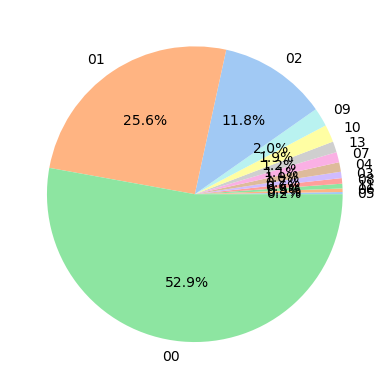

Detailed Rel. Other Rel.
{'0': 'N/a Gq/not Other Rel.', '1': 'Son in Law/daughter in Law', '2': 'Father in Law/mother in Law', '3': 'Brother in Law/sister in Law', '4': 'Nephew/niece', '5': 'Grandparent', '6': 'Uncle/aunt', '7': 'Cousin', '8': 'Other Related by Blood or Marriage', '9': 'Other Rel.'}


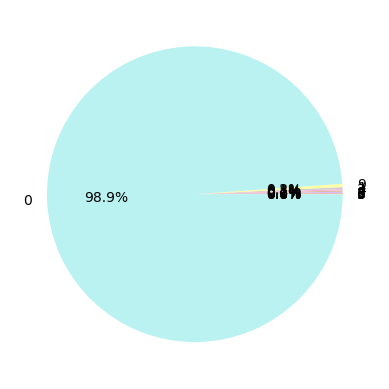

Subfam. Rel.
{'0': 'N/a Gq/not in a Subfam.', '1': 'Husband/wife', '2': 'Parent in a Parent/child Subfam.', '3': 'Child in Subfam.'}


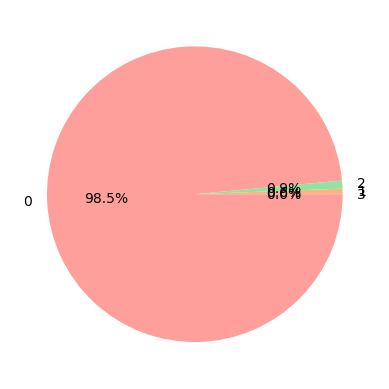

Subfam. Number
{'0': 'N/a Gq/not in a Subfam.', '1': 'In Subfam. 1', '2': 'In Subfam. 2', '3': 'In Subfam. 3'}


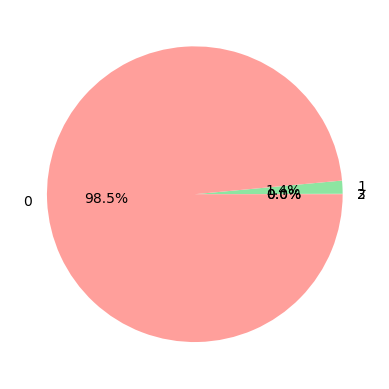

Related Child See Appendix B. Page 14
{'0': 'Not Related Child', '1': 'Related Child'}


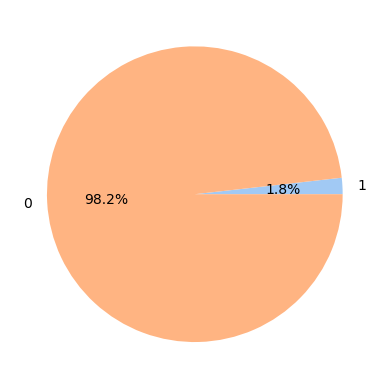

Employment Stat. of Parents
{'000': 'N/a Not Own Child of Hshldr., and Not Ch', '111': 'Both Parents At Work 35 or More Hrs.', '112': 'Father Only At Work 35 or More Hrs.', '113': 'Mother Only At Work 35 or More Hrs.', '114': 'Neither Parent At Work 35 or More Hrs.', '121': 'Father At Work 35 or More Hrs.', '122': 'Father Not At Work 35 or More Hrs.', '133': 'Mother At Work 35 or More Hrs.', '134': 'Mother Not At Work 35 or More Hrs.', '141': 'Neither Parent in Labor Force', '211': 'Father At Work 35 or More Hrs.', '212': 'Father Not At Work 35 or More Hrs.', '213': 'Father Not in Labor Force', '221': 'Mother At Work 35 or More Hrs.', '222': 'Mother Not At Work 35 or More Hrs.', '223': 'Mother Not in Labor Force'}


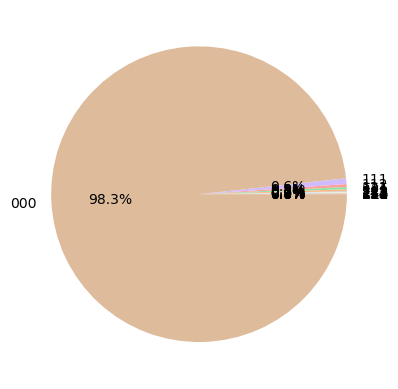

In [96]:
print(describe_feature('RELAT1'))
print(all_codes['RELAT1'])
_class_balance(df, 'RELAT1')

print(describe_feature('RELAT2'))
print(all_codes['RELAT2'])
_class_balance(df, 'RELAT2')

print(describe_feature('SUBFAM1'))
print(all_codes['SUBFAM1'])
_class_balance(df, 'SUBFAM1')

print(describe_feature('SUBFAM2'))
print(all_codes['SUBFAM2'])
_class_balance(df, 'SUBFAM2')

print(describe_feature('RRELCHLD'))
print(all_codes['RRELCHLD'])
_class_balance(df, 'RRELCHLD')

print(describe_feature('REMPLPAR'))
print(all_codes['REMPLPAR'])
_class_balance(df, 'REMPLPAR')


In [97]:
# now drop the features we have identified as being highly imbalanced
df = df.drop(['RELAT2', 
              'SUBFAM1', 
              'SUBFAM2', 
              'RRELCHLD', 
              'REMPLPAR'], axis=1)

### 2.8 Remove Low Cardinality Features

With the reduction of records and filtering applied so far; some columns may only contain single values and these will have no use for ML

In [98]:
# low cardinality suggests not categorical
low_card_cols = []
for name, low_card in (df.nunique(axis=0) <2).items():
    if low_card:
        print(f"{name:<10} -> {describe_feature(name)}")
        low_card_cols += [name]
        
df = df.drop(low_card_cols, axis=1)

AVAIL      -> Available for Work
DISABL2    -> Work Prevented Stat.
RECTYPE    -> Rec. Type
RLABOR     -> Employment Stat. Recode
TMPABSNT   -> Temp. Absence From Work
YEARWRK    -> Yr. Last Worked
count      -> 


# Stage 3 : Save the Clean Data

In [99]:
df.shape

(1118457, 59)

In [101]:
for x in list(df.columns):
    print(f"{x:<20} - {describe_feature(x)}")

AGE                  - Age
ANCSTRY1             - Ancestry First Entry See Appendix I Ance
ANCSTRY2             - Ancestry Second Entry See Appendix I Anc
CITIZEN              - Citizenship
CLASS                - Class of Worker
DEPART               - Time of Departure for Work Hour and Minu
DISABL1              - Work Limitation Stat.
ENGLISH              - Ability to Speak English
FEB55                - Served February 1955 July 1964
FERTIL               - No. of Chld. Ever Born
HISPANIC             - Detailed Hispanic Origin Code See Append
HOUR89               - Usual Hrs. Worked Per Week Last Yr. 1989
HOURS                - Hrs. Worked Last Week
IMMIGR               - Yr. of Entry
INDUSTRY             - Ind. See Appendix I Ind..lst
KOREAN               - Served Korean Conflict June 1950 January
LANG1                - Language Other Than English At Home
LANG2                - Language Spoken At Home See Appendix I L
MARITAL              - Marital Stat.
MAY75880             - Served

In [102]:
df.to_csv('us_census_data_cleaned_5.csv')

# Other (Tidy Up)

In [104]:
describe_feature('RRELCHLD')

'Related Child See Appendix B. Page 14'

In [81]:
all_codes['RRELCHLD']

{'0': 'Not Related Child', '1': 'Related Child'}

In [126]:
def combine_rare_classes(df, col, r=0.1, map_to='other'):
    
    gb = df[[col]].copy()
    gb['count'] = 1
    gb = gb[[col, 'count']].copy().groupby(col).sum().reset_index().sort_values(col, ascending=False)
    gb['count'] = 100*gb['count'] / sum(gb['count'])
    
    mapper = {k:map_to for k in gb[gb['count'] < r][col].values}
    
    return mapper, gb

mapper, gb = combine_rare_classes(df, 'RACE', 2.0, map_to = 'Other Race 700 799, 986 999')
df['RACE2'] = df['RACE'].apply(lambda x: mapper.get(x, x))

In [127]:
mapper, gb = combine_rare_classes(df, 'RACE', 2.0, map_to = 'Other Race 700 799, 986 999')
df['RACE2'] = df['RACE'].apply(lambda x: mapper.get(x, x))


None


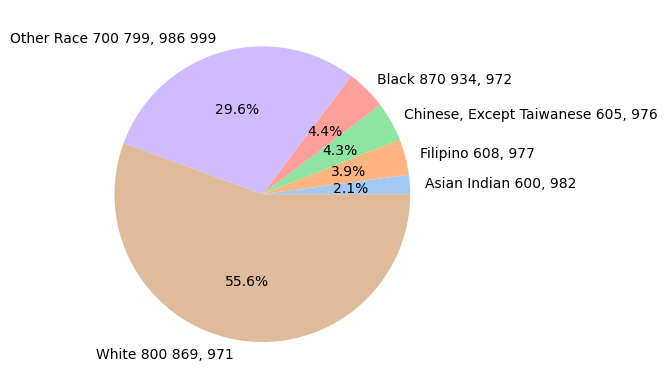

In [128]:
attr = 'RACE2'
print(describe_feature(attr))
print(all_codes.get(attr,None))
_class_balance(df, attr)

In [114]:
df[['IMMIGR','PWGT1']].groupby('IMMIGR').sum()

,PWGT1
IMMIGR,
00,5662691.0
01,1141582.0
02,832102.0
03,882575.0
04,1035009.0
05,1470019.0
06,1228819.0
07,869234.0
08,596167.0


In [195]:
# create column POB = USA or non-USA
df['POB_T'] = df['POB'].apply(lambda x: all_codes['POB'][x])
df['POB_T'] = df['POB_T'].apply(lambda x: 'United States' if x in states + ['U.S. Territory, Not Specified'] else x)
df.groupby('POB_T').count().sort_values('AGE')['AGE']
df['POB_USA'] = df['POB_T'].apply(lambda x: True if x=='United States' else False)

In [196]:
df.groupby('POB_USA').count()['AGE']

POB_USA
False    82129
True     55841
Name: AGE, dtype: int64

In [197]:
df_pob = df.groupby('POB').count().sort_values('AGE', ascending=False).reset_index()
df_pob['POB'] = df_pob['POB'].apply(lambda x: all_codes['POB'][x])
df_pob['POB'] = df_pob['POB'].apply(lambda x: 'United States' if x in states + ['U.S. Territory, Not Specified'] else x)


df_pob.head(25)

,POB,AGE,ANCSTRY1,ANCSTRY2,ASERVPER,AVETS1,CITIZEN,CLASS,DEPART,DISABL1,...,YEARSCH,YRSSERV,YEARSCH_CAT,OCCUP_JOB,OCCUP_SUM,OCCUP_MAJ,INDUSTRY_CAT,INDUSTRY_SUM,POB_T,POB_USA
0,Mexico,21433,21433,21433,21433,21433,21433,21433,21433,21433,...,21433,21433,21433,21433,21433,21433,21433,21433,21433,21433
1,United States,11466,11466,11466,11466,11466,11466,11466,11466,11466,...,11466,11466,11466,11466,11466,11466,11466,11466,11466,11466
2,United States,7555,7555,7555,7555,7555,7555,7555,7555,7555,...,7555,7555,7555,7555,7555,7555,7555,7555,7555,7555
3,United States,5965,5965,5965,5965,5965,5965,5965,5965,5965,...,5965,5965,5965,5965,5965,5965,5965,5965,5965,5965
4,Philippines,5161,5161,5161,5161,5161,5161,5161,5161,5161,...,5161,5161,5161,5161,5161,5161,5161,5161,5161,5161
5,Puerto Rico,3840,3840,3840,3840,3840,3840,3840,3840,3840,...,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840
6,Cuba,3828,3828,3828,3828,3828,3828,3828,3828,3828,...,3828,3828,3828,3828,3828,3828,3828,3828,3828,3828
7,"Abroad, Not Specified",2827,2827,2827,2827,2827,2827,2827,2827,2827,...,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827
8,China,2619,2619,2619,2619,2619,2619,2619,2619,2619,...,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619
9,Vietnam,2505,2505,2505,2505,2505,2505,2505,2505,2505,...,2505,2505,2505,2505,2505,2505,2505,2505,2505,2505


In [165]:
df_pob[df_pob['AGE'] < 10]['POB'].values

array(['Cameroon', 'Netherlands Antilles', 'West Berlin',
       'Yemen, Peoples Democratic Repub.', 'Barbados', 'Kiribati',
       'Asia, Not Specified', 'Suriname', 'Palau', 'Luxembourg',
       'Ivory Coast', 'Mauritius', 'Europe, Not Specified', 'Wales',
       'St. Kitts Nevis', 'Zambia', 'North Korea', 'Papua New Guinea',
       'Guadeloupe', 'Gambia', 'Congo', 'French Polynesia',
       'St. Vincent and the Grenadines', 'Senegal', 'Bahrain',
       'San Marino', 'Marshall Islands', 'Namibia',
       'North America, Not Specified', 'Martinique', 'Grenada',
       'Oceania, Not Specified', 'Middle East, Not Specified',
       'Polynesia, Not Specified', 'Madeira Islands', 'New Zealand',
       'Northern Ireland', 'Jersey', 'Chad', 'Togo', 'Bermuda',
       'Swaziland', 'West Bank', 'Mongolia', 'Caribbean, Not Specified',
       'Madagascar', 'Malawi', 'Nauru', 'Tuvalu', 'Gibraltar',
       'New Caledonia', 'Pitcairn Islands', 'Niue',
       'British West Indies, Not Specified', 'M

In [156]:
df_pob['POB'].apply(lambda x: 'USA' if x in states else x)

0                   Mexico
1                      USA
2                      USA
3                      USA
4              Philippines
              ...         
248    Antigua and Barbuda
249                Burundi
250           Burkina Faso
251             Montserrat
252                   Oman
Name: POB, Length: 253, dtype: object

In [149]:
states = ['Alaska',
 'California',
 'Hawaii',
 'Idaho',
 'Nevada',
 'Oregon',
 'Washington',
 'Arizona',
 'Arkansas',
 'Colorado',
 'Iowa',
 'Kansas',
 'Louisiana',
 'Minnesota',
 'Missouri',
 'Montana',
 'Nebraska',
 'New Mexico',
 'North Dakota',
 'Oklahoma',
 'South Dakota',
 'Texas',
 'Utah',
 'Wyoming',
 'Alabama',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Illinois',
 'Indiana',
 'Kentucky',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Mississippi',
 'New Hampshire',
 'New Jersey',
 'New York',
 'North Carolina',
 'Ohio',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'Tennessee',
 'Vermont',
 'Virginia',
 'West Virginia',
 'Wisconsin']

In [177]:
for p in df_pob['POB'].unique():
    print(p)

Mexico
USA
Philippines
Puerto Rico
Cuba
Abroad, Not Specified
China
Vietnam
India
El Salvador
Korea, Not Specified
Italy
Colombia
Germany, Not Specified
Poland
Dominican Repub.
Taiwan
Guatemala
Japan
Haiti
Portugal
Iran
Greece
Nicaragua
Peru
Union of Soviet Soc.ist Repub.s U.S.
Ecuador
Hong Kong
Canada
Yugoslavia
West Germany
Laos
Argentina
Honduras
France
Thailand
Pakistan
Brazil
Lebanon
South Korea
Cambodia
Hungary
Israel
Panama
Spain
Egypt
Chile
Romania
Czechoslovakia
Netherlands
Costa Rica
Nigeria
Indonesia
Venezuela
Iraq
Austria
Turkey
Bolivia
Switzerland
Syria
Ethiopia
Jordan
England
Azores Islands
Burma
Malaysia
Sweden
Uruguay
Jamaica
Bangladesh
Ireland
Palestine, Not Specified
Ghana
Belgium
Guam
Denmark
Norway
Latvia
Kenya
Fiji
Afghanistan
Dominica
Finland
Morocco
Lithuania
Africa, Not Specified
Sri Lanka
South Africa
Cyprus
Singapore
Western Samoa
Cape Verde
Belize
Paraguay
American Samoa
Guyana
Bulgaria
Macau
Tonga
United Kingdom, Not Specified
Trinidad and Tobago
South Ameri

In [181]:
import pycountry_convert as pc

country_code = pc.country_name_to_country_alpha2("China", cn_name_format="default")
print(country_code)
continent_name = pc.country_alpha2_to_continent_code(country_code)
print(continent_name)

CN
AS


In [182]:
pc.country_name_to_country_alpha2("China", cn_name_format="default")

'CN'

In [189]:
pc.country_mappings.map_countries()['China']['alpha_2']

'CN'

In [190]:
pc.country_alpha2_to_continent_code(pc.country_mappings.map_countries()['China']['alpha_2'])

'AS'

In [244]:
country_map = pc.country_mappings.map_countries()

map_non_country_to_continent = {
    'Korea, Not Specified'                 : 'AS',
    'Germany, Not Specified'               : 'EU',
    'Union of Soviet Soc.ist Repub.s U.S.' : 'EU',
    'Yugoslavia'                           : 'EU',
    'West Germany'                         : 'EU',
    'East Germany'                         : 'EU',
    'West Berlin'                          : 'EU',
    'Palestine, Not Specified'             : 'AS',
    'West Bank'                            : 'AS',
    'Middle East, Not Specified'           : 'AS',
    'Indochina, Not Specified'             : 'AS',
    'Asia Minor, Not Specified'            : 'AS',
    'Europe, Not Specified'                : 'EU',
    'Central America, Not Specified'       : 'SA',
    'Scotland'                             : 'EU',
    'United Kingdom, Not Specified'        : 'EU',
    'South America, Not Specified'         : 'SA',
    'Northern Ireland'                     : 'EU',
    'Eastern Africa, Not Specified'        : 'AF',
    'Central Africa, Not Specified'        : 'AF',
    'Africa, Not Specified'                : 'AF',
    'North America, Not Specified'         : 'NA',
    'St. Vincent and the Grenadines'       : 'NA',
    'Dominican Repub.'                     : 'NA',
    'Czechoslovakia'                       : 'EU',
    'England'                              : 'EU',
    'Burma'                                : 'AS',
    'Azores Islands'                       : 'EU',
    'Madeira Islands'                      : 'EU',
    'Caribbean, Not Specified'             : 'NA',
    'Asia, Not Specified'                  : 'AS',
    'Western Africa, Not Specified'        : 'AF',
    'Yemen, Peoples Democratic Repub.'     : 'AS',
    'Yemen Arab Repub.'                    : 'AS',
    'Oceania, Not Specified'               : 'OC',
    'British West Indies, Not Specified'   : 'NA',
    'West Indies, Not Specified'           : 'NA',
    'Pitcairn Islands'                     : 'OC',
    'Western Samoa'                        : 'OC',
    'U.S. Virgin Islands'                  : 'NA',
    'Netherlands Antilles'                 : 'NA',
    'Wales'                                : 'EU',
    'St. Kitts Nevis'                      : 'NA',
    'Polynesia, Not Specified'             : 'OC'
}

partial_map = {x:country_map.get(x,{'alpha_2':'Unknown'})['alpha_2'] for x in df_pob['POB'].unique()}


for k,v in partial_map.items():
    if v == 'Unknown':
        partial_map[k] = map_non_country_to_continent.get(k, 'Unknown')
    else:
        try:
            partial_map[k] = pc.country_alpha2_to_continent_code(v)
        except:
            print(k, v)
            partial_map[k] = 'Unknown'


In [245]:
df['POB_CONTINENT'] = df['POB_T'].apply(lambda x: partial_map[x])

In [246]:
df.groupby('POB_CONTINENT').count()['AGE']

POB_CONTINENT
AF          1379
AS         23135
EU         11913
NA         93514
OC           382
SA          4804
Unknown     2843
Name: AGE, dtype: int64

In [258]:
map_non_country_to_country = {
    'Korea, Not Specified'                 : 'South Korea',
    
    'Germany, Not Specified'               : 'Germany',
    'West Germany'                         : 'Germany',
    'East Germany'                         : 'Germany',
    'West Berlin'                          : 'Germany',
    
    'Union of Soviet Soc.ist Repub.s U.S.' : 'Russia',
    
    'Palestine, Not Specified'             : 'Palestine',
    'West Bank'                            : 'Palestine',

    'St. Vincent and the Grenadines'       : 'St. Vincent and The Grenadines',
    'St. Kitts Nevis'                      : 'Saint Kitts and Nevis',
    'Dominican Repub.'                     : 'Dominican Republic',
    'Czechoslovakia'                       : 'Czech Republic',

    'Burma'                                : 'Myanmar',
    
    'Azores Islands'                       : 'Portugal',
    'Madeira Islands'                      : 'Portugal',

    'Yemen, Peoples Democratic Repub.'     : 'Yemen',
    'Yemen Arab Repub.'                    : 'Yemen',

    'Pitcairn Islands'                     : 'Pitcairn',
    'Western Samoa'                        : 'Samoa',
    'U.S. Virgin Islands'                  : 'Virgin Islands, U.S.',
    
    
    'Northern Ireland'                     : 'UK',
    'England'                              : 'UK',
    'Wales'                                : 'UK',
    'Scotland'                             : 'UK',
    'United Kingdom, Not Specified'        : 'UK',
    
    
    'Netherlands Antilles'                 : 'Unknown',
    'British West Indies, Not Specified'   : 'Unknown',
    'West Indies, Not Specified'           : 'Unknown',
    'Western Africa, Not Specified'        : 'Unknown',
    'South America, Not Specified'         : 'Unknown',
    'North America, Not Specified'         : 'Unknown',
    'Eastern Africa, Not Specified'        : 'Unknown',
    'Central Africa, Not Specified'        : 'Unknown',
    'Africa, Not Specified'                : 'Unknown',
    'Asia, Not Specified'                  : 'Unknown',
    'Caribbean, Not Specified'             : 'Unknown',
    'Oceania, Not Specified'               : 'Unknown',
    'Yugoslavia'                           : 'Unknown',
    'Middle East, Not Specified'           : 'Unknown',
    'Indochina, Not Specified'             : 'Unknown',
    'Asia Minor, Not Specified'            : 'Unknown',
    'Europe, Not Specified'                : 'Unknown',
    'Central America, Not Specified'       : 'Unknown',
    'Polynesia, Not Specified'             : 'Unknown'
}

partial_map_c = {x:country_map.get(x,{'alpha_2':'Unknown'})['alpha_2'] for x in df_pob['POB'].unique()}
for k,v in partial_map_c.items():
    if v == 'Unknown':
        partial_map_c[k] = country_map.get(map_non_country_to_country.get(k), {'alpha_2':'Unknown'})['alpha_2']

In [261]:
df['POB_COUNTRY'] = df['POB_T'].apply(lambda x: partial_map_c[x])

In [265]:
df.groupby('POB_COUNTRY').count().sort_values('AGE', ascending=False).head(25)

,AGE,ANCSTRY1,ANCSTRY2,ASERVPER,AVETS1,CITIZEN,CLASS,DEPART,DISABL1,ENGLISH,...,YRSSERV,YEARSCH_CAT,OCCUP_JOB,OCCUP_SUM,OCCUP_MAJ,INDUSTRY_CAT,INDUSTRY_SUM,POB_T,POB_USA,POB_CONTINENT
POB_COUNTRY,,,,,,,,,,,,,,,,,,,,,
US,55841,55841,55841,55841,55841,55841,55841,55841,55841,55841,...,55841,55841,55841,55841,55841,55841,55841,55841,55841,55841
MX,21433,21433,21433,21433,21433,21433,21433,21433,21433,21433,...,21433,21433,21433,21433,21433,21433,21433,21433,21433,21433
PH,5161,5161,5161,5161,5161,5161,5161,5161,5161,5161,...,5161,5161,5161,5161,5161,5161,5161,5161,5161,5161
Unknown,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,...,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859
PR,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,...,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840
CU,3828,3828,3828,3828,3828,3828,3828,3828,3828,3828,...,3828,3828,3828,3828,3828,3828,3828,3828,3828,3828
CN,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619,...,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619
KR,2563,2563,2563,2563,2563,2563,2563,2563,2563,2563,...,2563,2563,2563,2563,2563,2563,2563,2563,2563,2563
VN,2505,2505,2505,2505,2505,2505,2505,2505,2505,2505,...,2505,2505,2505,2505,2505,2505,2505,2505,2505,2505


In [253]:
cunts = list(country_map.keys())
cunts.sort()
cunts

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Arab Republic of Egypt',
 'Argentina',
 'Argentine Republic',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivarian Republic of Venezuela',
 'Bolivia',
 'Bolivia, Plurinational State of',
 'Bonaire',
 'Bonaire, Sint Eustatius and Saba',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos (Keeling) Islands',
 'Colombia',
 'Commonwealth of Dominica',
 'Commonwealth of the Bahamas',
 'Commonweal

In [280]:
df.columns

Index(['AGE', 'ANCSTRY1', 'ANCSTRY2', 'ASERVPER', 'AVETS1', 'CITIZEN', 'CLASS',
       'DEPART', 'DISABL1', 'ENGLISH', 'FEB55', 'FERTIL', 'HISPANIC', 'HOUR89',
       'HOURS', 'IMMIGR', 'INDUSTRY', 'KOREAN', 'MARITAL', 'MAY75880', 'MEANS',
       'MIGPUMA', 'MIGSTATE', 'MILITARY', 'MOBILITY', 'MOBILLIM', 'OCCUP',
       'OTHRSERV', 'PERSCARE', 'POB', 'POWPUMA', 'POWSTATE', 'PWGT1', 'RACE',
       'RAGECHLD', 'REARNING', 'RELAT1', 'RELAT2', 'REMPLPAR', 'RIDERS',
       'RPOB', 'RRELCHLD', 'RSPOUSE', 'RVETSERV', 'SCHOOL', 'SEPT80', 'SEX',
       'SUBFAM1', 'SUBFAM2', 'TRAVTIME', 'VIETNAM', 'WEEK89', 'WORK89',
       'WORKLWK', 'WWII', 'YEARSCH', 'YRSSERV', 'YEARSCH_CAT', 'OCCUP_JOB',
       'OCCUP_SUM', 'OCCUP_MAJ', 'INDUSTRY_CAT', 'INDUSTRY_SUM', 'POB_T',
       'POB_USA', 'POB_CONTINENT', 'POB_COUNTRY'],
      dtype='object')

In [281]:
describe_feature('RAGECHLD')

'Presence and Age of Own Chld.'

In [287]:
all_codes['RSPOUSE']

{'0': 'N/a Less Than 15 Yrs. Old',
 '1': 'Now Married, Spouse Present',
 '2': 'Now Married, Spouse Absent',
 '3': 'Widowed',
 '4': 'Divorced',
 '5': 'Separated',
 '6': 'Never Married'}

In [284]:
df.groupby('RAGECHLD').count()

,AGE,ANCSTRY1,ANCSTRY2,ASERVPER,AVETS1,CITIZEN,CLASS,DEPART,DISABL1,ENGLISH,...,YEARSCH_CAT,OCCUP_JOB,OCCUP_SUM,OCCUP_MAJ,INDUSTRY_CAT,INDUSTRY_SUM,POB_T,POB_USA,POB_CONTINENT,POB_COUNTRY
RAGECHLD,,,,,,,,,,,,,,,,,,,,,
0,79335,79335,79335,79335,79335,79335,79335,79335,79335,79335,...,79335,79335,79335,79335,79335,79335,79335,79335,79335,79335
1,5541,5541,5541,5541,5541,5541,5541,5541,5541,5541,...,5541,5541,5541,5541,5541,5541,5541,5541,5541,5541
2,13812,13812,13812,13812,13812,13812,13812,13812,13812,13812,...,13812,13812,13812,13812,13812,13812,13812,13812,13812,13812
3,4979,4979,4979,4979,4979,4979,4979,4979,4979,4979,...,4979,4979,4979,4979,4979,4979,4979,4979,4979,4979
4,34303,34303,34303,34303,34303,34303,34303,34303,34303,34303,...,34303,34303,34303,34303,34303,34303,34303,34303,34303,34303


In [314]:
describe_feature('MIGSTATE')

'Migration State or Foreign Country Code'

In [288]:
df['RSPOUSE'].unique()

array(['1', '4', '6', '2', '5', '3'], dtype=object)

In [316]:
df.groupby('MIGSTATE').count()['AGE']

MIGSTATE
00    61393
01      215
02      137
04     1351
05      104
06    18467
08      764
09      705
10       30
11      189
12     4079
13      603
15      464
16      166
17     2918
18      508
19      179
20      277
21      183
22      645
23      159
24      899
25     1375
26      831
27      372
28      140
29      344
30       89
31      148
32      331
33      136
34     2610
35      954
36     5689
37      496
38       52
39      955
40      345
41      425
42     1076
44      189
45      277
46       81
47      265
48     8450
49      307
50       43
51      997
53      875
54       70
55      408
56       59
72      646
98    14500
Name: AGE, dtype: int64

In [324]:
all_codes['POWSTATE']

{'00': 'N/a Not a Worker Not in the Labor Force,',
 '01': 'Alabama',
 '02': 'Alaska',
 '04': 'Arizona',
 '05': 'Arkansas',
 '06': 'California',
 '08': 'Colorado',
 '09': 'Connecticut',
 '10': 'Delaware',
 '11': 'District of Columbia',
 '12': 'Florida',
 '13': 'Georgia',
 '15': 'Hawaii',
 '16': 'Idaho',
 '17': 'Illinois',
 '18': 'Indiana',
 '19': 'Iowa',
 '20': 'Kansas',
 '21': 'Kentucky',
 '22': 'Louisiana',
 '23': 'Maine',
 '24': 'Maryland',
 '25': 'Massachusetts',
 '26': 'Michigan',
 '27': 'Minnesota',
 '28': 'Mississippi',
 '29': 'Missouri',
 '30': 'Montana',
 '31': 'Nebraska',
 '32': 'Nevada',
 '33': 'New Hampshire',
 '34': 'New Jersey',
 '35': 'New Mexico',
 '36': 'New York',
 '37': 'North Carolina',
 '38': 'North Dakota',
 '39': 'Ohio',
 '40': 'Oklahoma',
 '41': 'Oregon',
 '42': 'Pennsylvania',
 '44': 'Rhode Island',
 '45': 'South Carolina',
 '46': 'South Dakota',
 '47': 'Tennessee',
 '48': 'Texas',
 '49': 'Utah',
 '50': 'Vermont',
 '51': 'Virginia',
 '53': 'Washington',
 '54': '

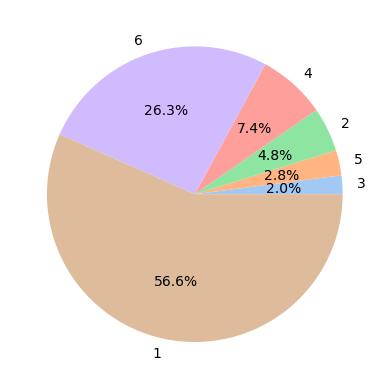

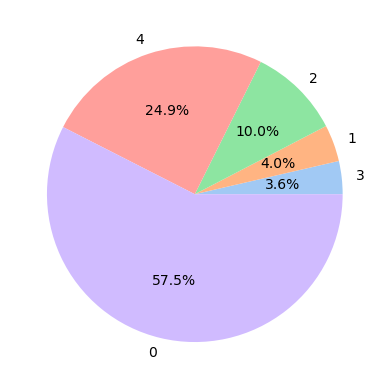

In [313]:
_class_balance(df, 'RSPOUSE')
_class_balance(df, 'RAGECHLD')

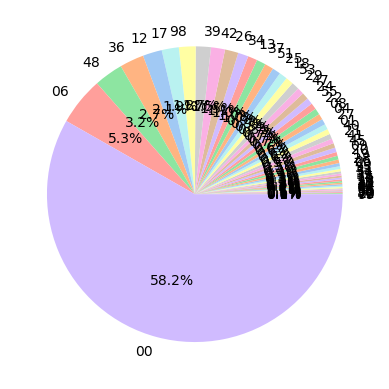

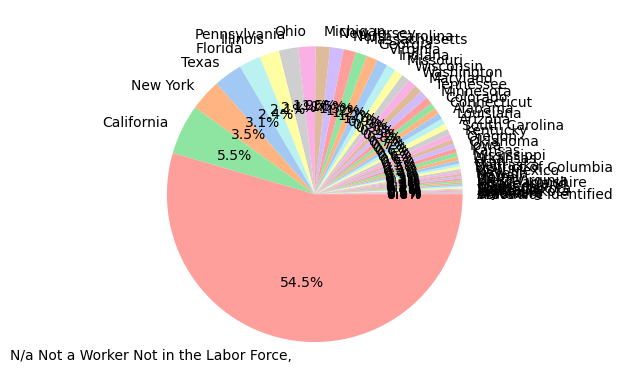

In [377]:
_class_balance(df, 'MIGSTATE')
_class_balance(df, 'POWSTATE')

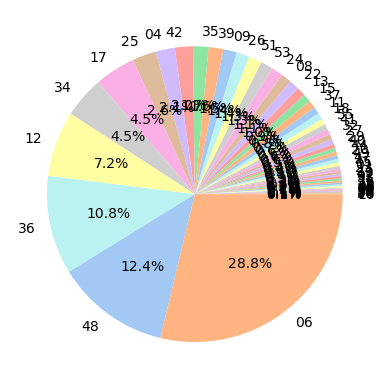

In [318]:
_class_balance(df, 'RPOB')

In [325]:
# migration
df[df['POWSTATE'] == df["MIGSTATE"]]

,AGE,ANCSTRY1,ANCSTRY2,ASERVPER,AVETS1,CITIZEN,CLASS,DEPART,DISABL1,ENGLISH,...,OCCUP_JOB,OCCUP_SUM,OCCUP_MAJ,INDUSTRY_CAT,INDUSTRY_SUM,POB_T,POB_USA,POB_CONTINENT,POB_COUNTRY,count
9,30,999,999,0,0,True,"Local Gov. Emp. City, County, Etc.",0800,2,1,...,"Cooks (5214, 5215)",SERVICE OCCUPATIONS,"Service Occupations, Except Protective and Hou...",Elementary and secondary schools (821),PROFESSIONAL AND RELATED SERVICES,United States,True,NA,US,1
57,47,050,999,0,0,True,"Local Gov. Emp. City, County, Etc.",1430,2,1,...,"Police and detectives, public service (5132)",SERVICE OCCUPATIONS,Protective Service Occupations,"Justice, public order, and safety (92)",PUBLIC ADMINISTRATION,United States,True,NA,US,1
500,42,615,999,0,0,False,"Self Emp. in Own Not Incorp.d Business,",0700,2,1,...,Physicians (261),MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS,Professional Specialty Occupations,"Offices and clinics of physicians (801, 803)",PROFESSIONAL AND RELATED SERVICES,India,False,AS,IN,1
1275,26,234,999,0,0,False,Emp. of a Private for Profit Company or,0830,2,1,...,"Sales workers, apparel (4346)","TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT O...",Sales Occupations,"Apparel and accessory stores, except shoe (56,...",RETAIL TRADE,Colombia,False,SA,CO,1
1373,32,050,999,0,0,True,Emp. of a Private for Profit Company or,0400,2,1,...,"Assemblers (772, 774)","OPERATORS, FABRICATORS, AND LABORERS","Machine Operators, Assemblers, and Inspectors",Aircraft and parts (372),MANUFACTURING,United States,True,NA,US,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457137,37,032,026,0,0,True,"Self Emp. in Own Not Incorp.d Business,",0800,2,1,...,"Nursing aides, orderlies, and attendants (5236)",SERVICE OCCUPATIONS,"Service Occupations, Except Protective and Hou...","Health services, n.e.c. (807, 808, 809)",PROFESSIONAL AND RELATED SERVICES,United States,True,NA,US,1
2457216,19,922,999,0,0,True,Emp. of a Private for Profit Company or,0550,2,1,...,Waiters and waitresses (5213),SERVICE OCCUPATIONS,"Service Occupations, Except Protective and Hou...",Eating and drinking places (58),RETAIL TRADE,United States,True,NA,US,1
2457651,31,032,999,0,0,True,Emp. of a Private for Profit Company or,0800,2,1,...,Excavating and loading machine operators (8316),"OPERATORS, FABRICATORS, AND LABORERS",Transportation and Material Moving Occupations,"CONSTRUCTION (15, 16, 17)","CONSTRUCTION (15, 16, 17)",United States,True,NA,US,1
2458120,49,032,999,0,0,True,Emp. of a Private for Profit Company or,0700,2,1,...,Excavating and loading machine operators (8316),"OPERATORS, FABRICATORS, AND LABORERS",Transportation and Material Moving Occupations,MINING,MINING,United States,True,NA,US,1


In [352]:
# TODO : Sankey the fuck out of this

df_migration = df[['AGE','POWSTATE',"MIGSTATE"]].groupby(['POWSTATE',"MIGSTATE"]).count().reset_index()

df_migration = df_migration[(df_migration['POWSTATE'] != '00') & (df_migration['MIGSTATE'] != '00')]
# df_migration = df_migration[(df_migration['POWSTATE'] != '99') & (df_migration['MIGSTATE'] != '99')]


df_migration['POWSTATE'] = df_migration['POWSTATE'].apply(lambda x: all_codes['POWSTATE'][x])
df_migration['MIGSTATE'] = df_migration['MIGSTATE'].apply(lambda x: all_codes['MIGSTATE'][x])

df_migration.sort_values('AGE', ascending=False).head(25)

,POWSTATE,MIGSTATE,AGE
267,California,California,60293
2295,Texas,Texas,32559
1737,New York,New York,27109
525,Florida,Florida,22200
737,Illinois,Illinois,19514
1886,Ohio,Ohio,17170
2043,Pennsylvania,Pennsylvania,16021
1215,Michigan,Michigan,14856
1792,North Carolina,North Carolina,11200
1629,New Jersey,New Jersey,11121


In [353]:
df_migration['AGE'].sum()

546207

In [363]:
sum(df['AGE'].astype(int) < 18)

642580

In [366]:
list(df.columns)

['AAGE',
 'AANCSTR1',
 'AANCSTR2',
 'AAUGMENT',
 'ABIRTHPL',
 'ACITIZEN',
 'ACLASS',
 'ADEPART',
 'ADISABL1',
 'ADISABL2',
 'AENGLISH',
 'AFERTIL',
 'AGE',
 'AHISPAN',
 'AHOUR89',
 'AHOURS',
 'AIMMIGR',
 'AINCOME1',
 'AINCOME2',
 'AINCOME3',
 'AINCOME4',
 'AINCOME5',
 'AINCOME6',
 'AINCOME7',
 'AINCOME8',
 'AINDUSTR',
 'ALABOR',
 'ALANG1',
 'ALANG2',
 'ALSTWRK',
 'AMARITAL',
 'AMEANS',
 'AMIGSTAT',
 'AMOBLLIM',
 'AMOBLTY',
 'ANCSTRY1',
 'ANCSTRY2',
 'AOCCUP',
 'APERCARE',
 'APOWST',
 'ARACE',
 'ARELAT1',
 'ARIDERS',
 'ASCHOOL',
 'ASERVPER',
 'ASEX',
 'ATRAVTME',
 'AVAIL',
 'AVETS1',
 'AWKS89',
 'AWORK89',
 'AYEARSCH',
 'AYRSSERV',
 'CITIZEN',
 'CLASS',
 'DEPART',
 'DISABL1',
 'DISABL2',
 'ENGLISH',
 'FEB55',
 'FERTIL',
 'HISPANIC',
 'HOUR89',
 'HOURS',
 'IMMIGR',
 'INCOME1',
 'INCOME2',
 'INCOME3',
 'INCOME4',
 'INCOME5',
 'INCOME6',
 'INCOME7',
 'INCOME8',
 'INDUSTRY',
 'KOREAN',
 'LANG1',
 'LANG2',
 'LOOKING',
 'MARITAL',
 'MAY75880',
 'MEANS',
 'MIGPUMA',
 'MIGSTATE',
 'MILITARY',
 

In [368]:
df['PWGT1'].unique()

array(['0240', '0080', '0048', '0144', '0096', '0112', '0128', '0160',
       '0192', '0176', '0032', '0064', '0016', '0224', '0208', '0256',
       '0272', '0288', '0528', '0320', '0352', '0304', '0336', '0416',
       '0368', '0432', '0400', '0736', '0464', '0384', '0592', '0000',
       '0544', '0480', '0448', '0019', '0038', '0057', '0095', '0114',
       '0076', '0133', '0152', '0171', '0190', '0247', '0209', '0266',
       '0285', '0228', '0494', '0323', '0380', '0342', '0361', '0399',
       '0551', '0475', '0130', '0104', '0117', '0065', '0143', '0169',
       '0091', '0195', '0078', '0182', '0156', '0052', '0234', '0039',
       '0221', '0390', '0377', '0299', '0338', '0455', '0273', '0286',
       '0026', '0312', '0325', '0260', '0364', '0013', '0520', '0351',
       '0507', '0403', '0429', '0442', '0676', '0559', '0546', '0126',
       '0180', '0108', '0090', '0054', '0072', '0018', '0036', '0198',
       '0162', '0216', '0270', '0252', '0306', '0378', '0324', '0396',
      

In [369]:
all_codes['PWGT1']

{}

In [370]:
describe_feature('PWGT1')

'Pers. Wgt'

In [371]:
df['count'] = 1

In [374]:
sum(df['count'] * df['PWGT1'].astype(float))

243932360.0

In [376]:
df['RPOB']

0                          South
1          Born in State of Res.
2                          South
3          Born in State of Res.
4                          South
                   ...          
2458279    Born in State of Res.
2458280                     West
2458281                     West
2458282                     West
2458283                     West
Name: RPOB, Length: 2458284, dtype: object